# COMPUTATIONAL TOOLS FOR DATA SCIENCE

## 1. DATA PROCESSING AND VISUALIZATION

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px # for interactive plots
# pip install wordcloud
from wordcloud import WordCloud # for wordclouds
import re  # for regular expressions

In [135]:
file1 = '/Users/matteopiccagnoni/Desktop/DTU/Computational tools for data science/project/computationaltoolsDS/computationaltoolsDS/medicine_details.csv'
data = pd.read_csv(file1)

# Print the dataframes to verify
print("data from medicine_details.csv:")
print(data.head())  

data from medicine_details.csv:
              Medicine Name  \
0   Avastin 400mg Injection   
1  Augmentin 625 Duo Tablet   
2       Azithral 500 Tablet   
3          Ascoril LS Syrup   
4         Aciloc 150 Tablet   

                                         Composition  \
0                                Bevacizumab (400mg)   
1    Amoxycillin  (500mg) +  Clavulanic Acid (125mg)   
2                               Azithromycin (500mg)   
3  Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...   
4                                 Ranitidine (150mg)   

                                                Uses  \
0  Cancer of colon and rectum Non-small cell lung...   
1                  Treatment of Bacterial infections   
2                  Treatment of Bacterial infections   
3                      Treatment of Cough with mucus   
4  Treatment of Gastroesophageal reflux disease (...   

                                        Side_effects  \
0  Rectal bleeding Taste change Headache Noseblee..

### 1.1 VISUALIZATIONS

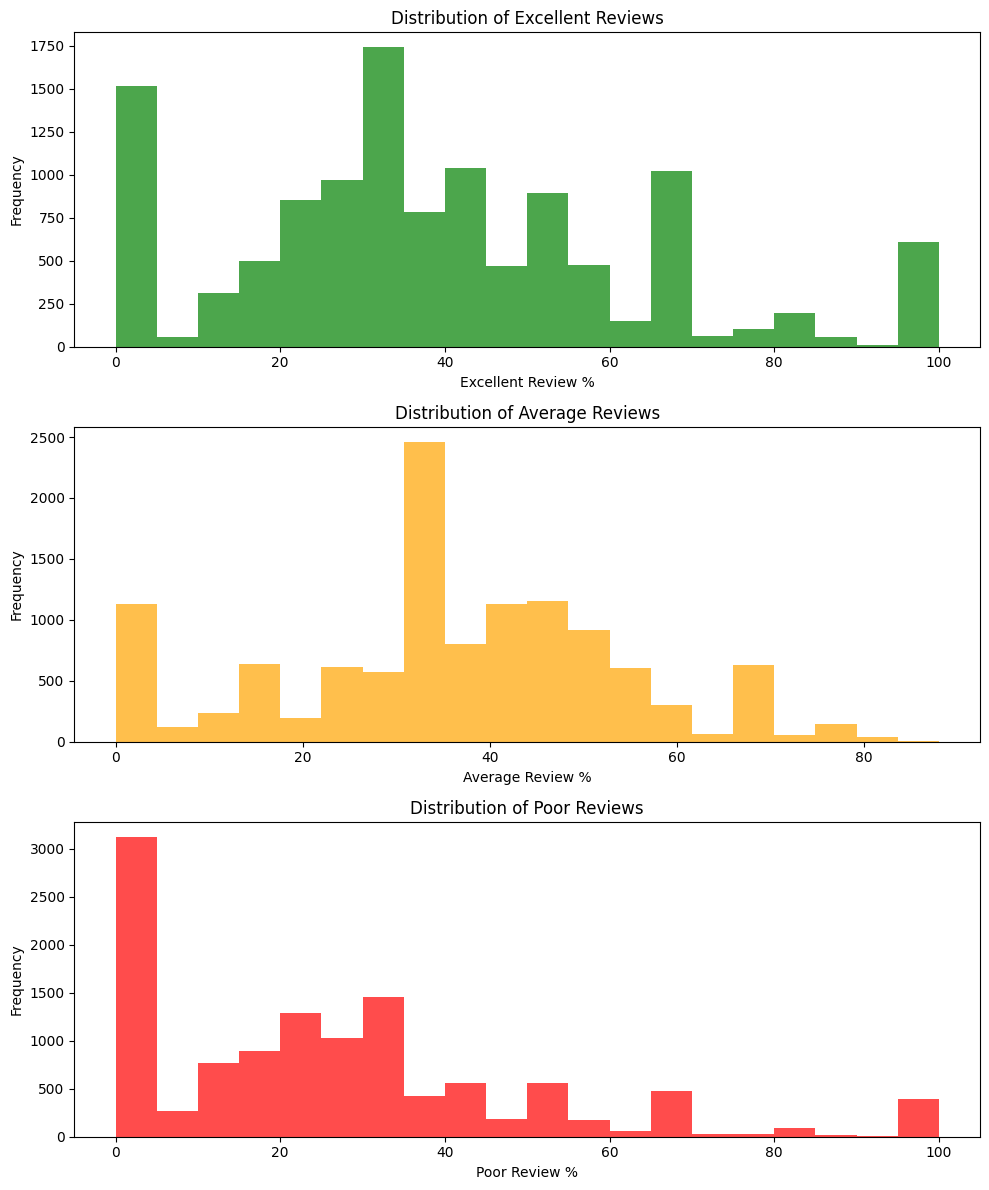

In [136]:
# three plot to see the distribution of the different percentages of reviews
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.hist(data['Excellent Review %'], bins=20, color='green', alpha=0.7)
ax1.set_title('Distribution of Excellent Reviews')
ax1.set_xlabel('Excellent Review %')
ax1.set_ylabel('Frequency')

ax2.hist(data['Average Review %'], bins=20, color='orange', alpha=0.7)
ax2.set_title('Distribution of Average Reviews')
ax2.set_xlabel('Average Review %')
ax2.set_ylabel('Frequency')

ax3.hist(data['Poor Review %'], bins=20, color='red', alpha=0.7)
ax3.set_title('Distribution of Poor Reviews')
ax3.set_xlabel('Poor Review %')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [137]:
# Define weights for each rating category. Here we're assuming:
#   Good ratings contribute positively to the score (scaled up)
#   Middle ratings contribute a neutral or mid-range value
#   Bad ratings contribute negatively to the score (scaled down)

good_weight = 10  # Max score for good ratings
middle_weight = 5 # Midpoint score for middle ratings
bad_weight = 0    # Min score for bad ratings

# Calculate the weighted score for each observation
data['Ratings'] = (
    data['Excellent Review %'] * good_weight +
    data['Average Review %'] * middle_weight +
    data['Poor Review %'] * bad_weight
) / 100  # Divide by 100 to bring it back to a 0-10 scale

# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', 1000)  
# print(data[['Ratings']])
print(data[['Ratings']].head())

   Ratings
0     5.00
1     6.45
2     5.90
3     4.45
4     5.25


In [138]:
# counting the number of manufacturers
print(data['Manufacturer'].value_counts())

Manufacturer
Sun Pharmaceutical Industries Ltd    820
Intas Pharmaceuticals Ltd            654
Cipla Ltd                            574
Torrent Pharmaceuticals Ltd          445
Lupin Ltd                            435
                                    ... 
Hicare Pharma                          1
Nexeum Pharmaceuticals                 1
Bio Swizz Pharmaceuticals              1
Nutratec Pharmaceuticals               1
Grevis Pharmaceuticals Pvt Ltd         1
Name: count, Length: 759, dtype: int64


In [139]:
# calculating the average rating for each manufacturer
manufacturer_ratings = data.groupby('Manufacturer')['Ratings'].mean().sort_values(ascending=False)
print(manufacturer_ratings)

Manufacturer
Medlius Pharma Pvt. Limited    10.0
Matias Healthcare Pvt Ltd      10.0
Ampra Pharmaceuticals          10.0
Matteo Healthcare Pvt Ltd      10.0
Lynderma Pharmaceuticals       10.0
                               ... 
Nicholas Healthcare Limited     0.0
Astra Labs                      0.0
Baxton Pharmacia                0.0
Arlak Biotech Pvt Ltd           0.0
Aarti Life Science              0.0
Name: Ratings, Length: 759, dtype: float64


In [140]:
# interactive plot to visualize the average ratings by manufacturer
# you can zoom in and out, hover over the bars to see the values
fig = px.bar(
    x=manufacturer_ratings.index,
    y=manufacturer_ratings.values,
    title='Average Ratings by Manufacturer',
    labels={'x': 'Manufacturer', 'y': 'Average Rating'}
)

fig.update_layout(
    height=600,
    width=2000, # number of manufacturers
    xaxis_tickangle=45,
    showlegend=False
)

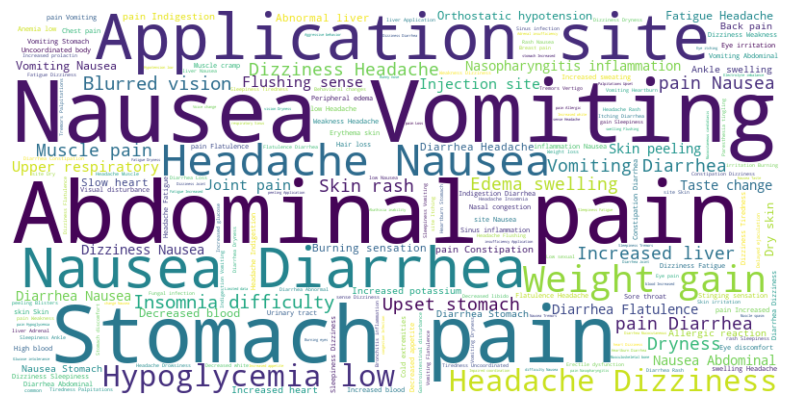

In [141]:
# Step 1: Split side effects based on capital letters and clean up the list
data['Side_effects'] = data['Side_effects'].apply(lambda x: re.findall(r'[A-Z][a-z]*\s?[a-z]*', x))

# Step 2: Combine all side effects into a single string for word cloud
all_side_effects = ' '.join([' '.join(effect) for effect in data['Side_effects']])

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_side_effects)

# Step 4: Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 1.2 DATA PROCESSING

In [142]:
# MARCO'S CODE TO CREATE A NEW COLUMN WITH THE NUMBER OF COMPONENTS
'''# Print the dataframe to verify the new feature
# print("data with ratings:")
# print(data)

# Step 1: Split the Composition column by " + " to get a list of components for each observation
data['Composition'] = data['Composition'].str.split('+')

# Step 2: Apply One-Hot Encoding
# This creates a dataFrame where each unique component is a column with 1 or 0 indicating presence in each row
one_hot_data = data['Composition'].str.join('|').str.get_dummies()

# Step 3: Concatenate the one-hot encoded columns back with the original dataFrame (if needed)
data2 = pd.concat([one_hot_data], axis=1)

# Display the resulting dataFrame
# print(data2.columns)
#following 2 lines printed the one hot ingredients for the second medicine to see if the one hot encoding of the strings it's correct
# second_row_dict = data2.iloc[1].to_dict()
# print(second_row_dict)
# print(data2.head())'''

'# Print the dataframe to verify the new feature\n# print("data with ratings:")\n# print(data)\n\n# Step 1: Split the Composition column by " + " to get a list of components for each observation\ndata[\'Composition\'] = data[\'Composition\'].str.split(\'+\')\n\n# Step 2: Apply One-Hot Encoding\n# This creates a dataFrame where each unique component is a column with 1 or 0 indicating presence in each row\none_hot_data = data[\'Composition\'].str.join(\'|\').str.get_dummies()\n\n# Step 3: Concatenate the one-hot encoded columns back with the original dataFrame (if needed)\ndata2 = pd.concat([one_hot_data], axis=1)\n\n# Display the resulting dataFrame\n# print(data2.columns)\n#following 2 lines printed the one hot ingredients for the second medicine to see if the one hot encoding of the strings it\'s correct\n# second_row_dict = data2.iloc[1].to_dict()\n# print(second_row_dict)\n# print(data2.head())'

In [143]:
# MATTEO'S CODE THAT USES MARCO'S BUT CLEANED THE COLUMNS NAMES
# Step 1: Split the Composition column by " + " to get a list of components for each observation
data['Composition'] = data['Composition'].str.split('+')

# Step 2: Apply One-Hot Encoding
one_hot_data = data['Composition'].str.join('|').str.get_dummies()
one_hot_data.columns = one_hot_data.columns.str.strip().str.lower().str.replace(' ', '_') # clean the name of the columns

# Step 3: Concatenate the one-hot encoded columns with the original data (including Medicine_Name)
data_final = pd.concat([data[['Medicine Name']], one_hot_data], axis=1)
data_final.columns = data_final.columns.str.strip().str.lower().str.replace(' ', '_') # clean the name of the columns

In [144]:
# Display the resulting dataframe to verify the new features
print("Data with One-Hot Encoded Composition:")
print(data_final.head())

Data with One-Hot Encoded Composition:
              medicine_name  human_insulin/soluble_insulin_(25%)  \
0   Avastin 400mg Injection                                    0   
1  Augmentin 625 Duo Tablet                                    0   
2       Azithral 500 Tablet                                    0   
3          Ascoril LS Syrup                                    0   
4         Aciloc 150 Tablet                                    0   

   human_insulin/soluble_insulin_(30%)  human_insulin/soluble_insulin_(50%)  \
0                                    0                                    0   
1                                    0                                    0   
2                                    0                                    0   
3                                    0                                    0   
4                                    0                                    0   

   acetylcysteine_(100mg)  albendazole_(200mg)  albendazole_(400mg)  \
0     